# Prototype: Compute cell volumes using lookup table in HEC-RAS HDF5 file

In [1]:
import pandas as pd
import numpy as np
import numba
import h5py

## Read data from HDF5

### Note:
If you encounter a KeyError, make sure the HDF5 is closed, and then reopen the file.

In [2]:
with h5py.File('../tests/input_files/Muncie.p04.hdf') as infile:
    # infile['Geometry/2D Flow Areas/2D Interior Area/Cells Surface Area'][()]
    cells_volume_info = infile['Geometry/2D Flow Areas/2D Interior Area/Cells Volume Elevation Info'][()]
    cells_elev_vol = infile['Geometry/2D Flow Areas/2D Interior Area/Cells Volume Elevation Values'][()]
    cells_surface_area_arr = infile['Geometry/2D Flow Areas/2D Interior Area/Cells Surface Area'][()]
    water_surface_elev_arr = infile['Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/2D Flow Areas/2D Interior Area/Water Surface'][()]

index_arr = cells_volume_info[:,0]
count_arr = cells_volume_info[:,1]
elev_arr = cells_elev_vol[:,0]
vol_arr = cells_elev_vol[:,1]

## Compute cell volume

In [3]:
@numba.njit
def compute_volume(water_surface_elev_arr: np.array, cells_surface_area_arr: np.array, index_arr: np.array, count_arr: np.array, elev_arr: np.array, vol_arr: np.array, time: int, cell: int, VERBOSE=False) -> float:
    water_surface_elev = water_surface_elev_arr[time, cell]
    surface_area = cells_surface_area_arr[cell]
    index = index_arr[cell] # Start index in the volume-elevation table for this cell
    count = count_arr[cell] # Number of points in the table for this cell

    # A number of cells have an index that is just past the end of the array. Return a volume of 0.0 for these cells. The count for these cells should also be zero, but
    # we are checking for either condition.
    if index >= len(elev_arr) or count == 0:
        return 0.0

    elev = elev_arr[index:index + count] # Get the elevation table for this cell
    vol = vol_arr[index:index + count] # Get the volume table for this cell

    if water_surface_elev > elev[-1]:
        # Compute the net volume: the max volume in the lookup table plus the volume of the water above the max elevation in the lookup table
        net_vol = vol[-1] + (water_surface_elev - elev[-1]) * surface_area
    elif water_surface_elev == elev[-1]:
        net_vol = vol[-1]
    elif water_surface_elev == elev[0]:
        net_vol = vol[0]
    else:
        # Interpolate
        net_vol = 0.0 # Default
        npts = len(elev)
        for i in range(npts-1, -1, -1):
            if elev[i] > water_surface_elev:
                x = water_surface_elev
                m = (vol[i] - vol[i-1])/(elev[i] - elev[i-1])
                x1 = elev[i]
                y1 = vol[i]
                # y = m * (x - x1) + y1
                net_vol = m * (x - x1) + y1

    if VERBOSE:
        print('water_surface_elev:', water_surface_elev)
        print('surface_area:', surface_area)
        print('index:', index)
        print('count:', count)
        print('cell:', cell)
        print('elev:', elev)
        print('len(elev_arr):', len(elev_arr))
        print('vol:', vol)
        print('net_vol:', net_vol)
    return net_vol

In [5]:
time = 288 # last time step
cell = 2000
compute_volume(water_surface_elev_arr, cells_surface_area_arr, index_arr, count_arr, elev_arr, vol_arr, time, cell, VERBOSE=True)

water_surface_elev: 945.1983032226562
surface_area: 2500.0
index: 13528
count: 8
cell: 2000
elev: [931.92554 931.9677  932.0444  932.18994 932.2435  932.28186 932.5883
 932.9024 ]
len(elev_arr): 37912
vol: [   0.           7.6705933   29.835289    86.64504    113.163666
  166.12132    650.05145   1421.8578   ]
net_vol: 32161.603515625


32161.603515625

In [6]:
@numba.njit
def compute(water_surface_elev_arr: np.array, cells_surface_area_arr: np.array, index_arr: np.array, count_arr: np.array, elev_arr: np.array, vol_arr: np.array, ntimes: int, ncells: int):
    cell_volumes = np.zeros((ntimes, ncells))

    for cell in range(ncells):
        for time in range(ntimes):
            cell_volumes[time, cell] = compute_volume(water_surface_elev_arr, cells_surface_area_arr, index_arr, count_arr, elev_arr, vol_arr, time, cell)

    return cell_volumes

## Example

In [7]:
ncells = 5765
ntimes = 289

cell_volumes = compute(water_surface_elev_arr, cells_surface_area_arr, index_arr, count_arr, elev_arr, vol_arr, ntimes, ncells)
cell_volumes_df = pd.DataFrame(cell_volumes, columns = range(ncells))
cell_volumes_df

,0,1,2,3,4,5,6,7,8,9,...,5755,5756,5757,5758,5759,5760,5761,5762,5763,5764
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,11781.545898,10580.918945,11696.687500,11255.155273,10983.076172,15212.147461,13285.705078,15499.646484,17601.767578,19045.613281,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
285,11777.916016,10577.850586,11693.376953,11251.775391,10979.221680,15208.108398,13282.004883,15495.236328,17596.714844,19040.261719,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
286,11774.286133,10574.782227,11690.066406,11248.395508,10975.367188,15204.069336,13278.303711,15490.826172,17591.662109,19035.130859,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
287,11770.656250,10571.713867,11686.755859,11245.014648,10971.513672,15200.031250,13274.603516,15486.416016,17586.609375,19029.556641,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0, 0.5, 'Cell Volume')

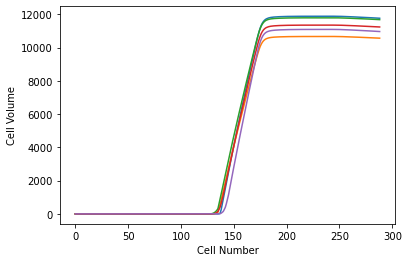

In [14]:
ax = cell_volumes_df[range(5)].plot(legend=None)
ax.set_xlabel('Cell Number')
ax.set_ylabel('Cell Volume')